# TensorFlow Eager

With TensorFlow 2, "[eager](https://www.tensorflow.org/guide/eager) execution" mode is enabled by default. This means that every tensor computation is executed directly as it is defined in Python. This is in line with many other frameworks (such as `numpy`).

Note that in earlier versions of TensorFlow, computations were separated into a "graph construction phase" and a "graph execution phase", which caused a steep learning curve in using the framework.

The new "eager execution" mode is intuitive to use and ideal for model development and experimentation.

For this Colab it's handy to keep [TensorFlow's API documentation](https://www.tensorflow.org/api_docs/python/tf) open in a separate browser tab.

In [1]:
# In Jupyter, you would need to install TF 2 via !pip.
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import json, os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

version=2.1.0-rc1, CUDA=True, GPU=True, TPU=False


> **Attention:** Please avoid using the TPU runtime (`TPU=True`) for now. The notebook contains an optional part on TPU usage at the end if you're interested. You can change the runtime via: "Runtime > Change runtime type > Hardware Accelerator" in Colab.

In [0]:
# Load data from Drive (Colab only).
data_path = '/content/gdrive/My Drive/amld_data/zoo_img'

# Or, you can load data from different sources, such as:
# From your local machine:
# data_path = './amld_data'

# Or use a prepared dataset from Cloud (Colab only).
# See https://console.cloud.google.com/storage/browser/amld-datasets
# - 50k training examples, including pickled DataFrame.
# data_path = 'gs://amld-datasets/zoo_img_small'

In [4]:
# (Copied from ./2_keras.ipynb)
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  drive.mount('/content/gdrive')
if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()
  !gsutil ls -lh "$data_path"
else:
  !ls -lh "$data_path"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 2.9G
-rw------- 1 root root   46 Jan 24 22:09 counts.json
-rw------- 1 root root 2.5G Jan 24 22:10 dataframe.pkl
-rw------- 1 root root  11M Jan 24 22:08 eval-00000-of-00010
-rw------- 1 root root  11M Jan 24 22:08 eval-00001-of-00010
-rw------- 1 root root  11M Jan 24 22:08 eval-00002-of-00010
-rw------- 1 root root  11M Jan 24 22:08 eval-00003-of-00010
-rw------- 1 root root  11M Jan 24 22:08 eval-00004-of-00010
-rw------- 1 root root  11M Jan 24 22:0

## Tensors

A Tensor can describe a scalar, vector, matrix, or higher dimensional data (also see
 [TF guide - Tensors](https://www.tensorflow.org/guide/tensors)).  The essential Tensor types include:

* `tf.constant`
* `tf.Variable`
* `tf.SparseTensor`
* More tensor types that we won't discuss in this Colab `tf.RaggedTensor`, `tf.TensorArray`.

The essential Tensor attributes are:

* Rank - number of dimensions
* Shape - number of elements in each dimension
* Data type - for example `tf.float32`: **must be the same for every dimension**

Let's look at the different Tensor types.

### Tensor types

**`tf.constant`** - A basic immutable Tensor

We can define a constant tensor with a shape of `[12]` (i.e. a vector with 12 elements).

In [5]:
tensor12 = tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
tensor12

<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)>

In [6]:
# Get the tensor data as a numpy ndarray:
tensor12.numpy()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

**`tf.Variable`** - A mutable Tensor

If we need to store state (e.g. the weight parameters of a network), then we use a mutable Tensor callled `tf.Variable`.

In [7]:
# Define a Variable with a known initial value.
weight = tf.Variable(0, dtype=float, name='weight')
weight

<tf.Variable 'weight:0' shape=() dtype=float32, numpy=0.0>

For updates, we can then make use of the `assign` operations TF provides.

Particularly, we can use operations like `.assign`, `.assign_add` and `.assign_sub`.

In [8]:
# YOUR ACTION REQUIRED:
# 1. Create a variable called `new_var`.
# 2. Assign the value 1531 to `new_var`.
# 3. Use `.assign_sub` to subtract 194.
new_var = tf.Variable(0, dtype=tf.int32)  #new_var =
new_var.assign(1531) #new_var.
new_var.assign_sub(194) #new_var.
print('Variable:', new_var)

Variable: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1337>


In [9]:
# Creating a variable and incrementing it:
v1 = tf.Variable(0)
v1.assign_add(1)
v1

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>

In [10]:
# MISTAKE: The following two statements will create a variable with the
# value 0 and then a tensor that is the variable plus one. The reference to the
# original variable is lost and any code using the reference to the original
# `v2` will still see the value 0.
v2 = tf.Variable(0)
v2 = v2 + 1
v2

<tf.Tensor: shape=(), dtype=int32, numpy=1>

**`tf.SparseTensor`** - A sparse representation Tensor

Sparse tensors can have an arbitrarily large shape, but they store only values that are different from the default value (usually `0`). This type is very useful for some applications, for example to represent a word with a one-hot encoding from a large dictionary.

Note that some TF functions (see [`tf.sparse`](https://www.tensorflow.org/api_docs/python/tf/sparse) module) only work with sparse tensors, while most TF functions except regular tensors as input.


In [0]:
# YOUR ACTION REQUIRED:
# Complete the arguments to `tf.SparseTensor` in the following statement to
# define a 3x3 matrix with ones on the \ diagonal and zeros everywhere else. 
# Hint: When complete type the "()" below, Colab will show the function's
# documentation.
#sparse_eye3 = tf.SparseTensor
#--snip
sparse_eye3 = tf.sparse.SparseTensor(dense_shape=[3,3], 
                                     indices=[[0,0],[1,1],[2,2]], 
                                     values=[1,1,1])

In [12]:
# Note that to display the values, we need to convert the sparse
# tensor to normal `tf.Tensor` (a "dense" tensor):
tf.sparse.to_dense(sparse_eye3)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int32)>

### Operator overloading & Broadcasting

In general, operator overloading allows to define custom behavior for basic operators like: -, +, /, and *. The result might depend on the arguments':
* Order
* Data type
* Content

TensorFlow makes use of operator overloading to simplify the core API as we will see below.

In addition, it makes use of something called Broadcasting.

> "Broadcasting is the process of making arrays with different shapes that have compatible shapes for arithmetic operations. The terminology is borrowed from [Numpy broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)." - see https://www.tensorflow.org/xla/broadcasting

Overall, this allows us to succinctly and efficiently operate with tensors of different shapes and types.  

In [13]:
# Broadcasting + operator overloading: Try to write the line below more 
# succinctly.

# YOUR ACTION REQUIRED: Simplify the given statement by making use of TF's
# operator overloading and Broadcasting.
tensor12_plus_1 = tensor12 + 1 #tensor12_plus_1 = tf.add(tensor12, tf.ones(shape=tensor12.shape, dtype=tf.int32))
tensor12_plus_1

<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32)>

TensorFlow accepts Python numbers or Numpy arrays in most places and converts them to tensors on the fly.

In [14]:
# YOUR ACTION REQUIRED:
# Try to replace one or both of the arguments with a
# tf.constant() or with a np.array() and see what happens. Use different shapes.
tf.add(1, 2)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [15]:
# YOUR ACTION REQUIRED:
# Use broadcasting to generate an array like this:
# [[11, 12, 13, ...],
#  [21, 22, 23, ...],
#  [31, 32, 33, ...],
#  ...,
# ]
# (Tip: use tf.range() & tf.reshape() or tf.expand_dims())
#--snip
tf.range(1, 6) + tf.expand_dims(tf.range(1, 6), 1) * 10

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[11, 12, 13, 14, 15],
       [21, 22, 23, 24, 25],
       [31, 32, 33, 34, 35],
       [41, 42, 43, 44, 45],
       [51, 52, 53, 54, 55]], dtype=int32)>

When applying an operation to Tensors they must be of the same datatype. In any other case, you might see a ValueError like below.

In [16]:
# YOUR ACTION REQUIRED: Try to change the datatype of one of the tensors to 
# fix the ValueError.
multiplier = tf.constant(1.5)
tf.cast(tensor12, tf.float32) * multiplier #tensor12 * multiplier

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([ 1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5,
       18. ], dtype=float32)>

### Accessing elements

Accessing individual elements of a 2D tensor.

In [17]:
# A batch of 3 zero padded vectors with different length:
# first vector = [1, 2, 3]
# second vector = [2, 4, 5, 8]
# third vector = [3, 6]
batch = tf.constant([[1, 2, 3, 0, 0],
                     [2, 4, 6, 8, 0],
                     [3, 6, 0, 0, 0]])

# Length of the vectors (without zero padding at end).
lengths = tf.constant([3, 4, 2])

# The FIRST elements can be accessed by using Python's overloaded indexing...
batch[0:3, 0:1].numpy()

array([[1],
       [2],
       [3]], dtype=int32)

In [18]:
# ... or explicitly using the TF SPI.
tf.slice(batch, [0, 0], [3, 1]).numpy()

array([[1],
       [2],
       [3]], dtype=int32)

Accessing the LAST (non-padded) element within every sequence is somewhat more involved.

You need to specify both the indices in the first and the second dimension and then use `tf.gather_nd()`.

In [19]:
# Accessing the last elements is slightly more involved:
indices_0 = list(range(3))
indices_1 = lengths - 1

# -> Go check out the documentation of tf.gather_nd().
tf.gather_nd(batch, tf.transpose([indices_0, indices_1]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 8, 6], dtype=int32)>

Below you have an integer tensor and then an expression that is set True for all elements that are odd.

Try to print those elements using the operations `tf.where()` and `tf.gather()`.


In [20]:
numbers = tf.range(1, 11)
odd_condition = tf.logical_not(tf.equal(0, tf.math.mod(numbers, 2)))

# YOUR ACTION REQUIRED:
# Provide the correct expression for `odd_indices` and `odd_numbers`.
# You can use `tf.where` and `tf.gather` to this.
odd_indices = tf.where(odd_condition) #odd_indices =
odd_numbers = tf.gather(numbers, odd_indices) #odd_numbers =
odd_numbers.numpy()

array([[1],
       [3],
       [5],
       [7],
       [9]], dtype=int32)

### Shape manipulation

**Basic reshaping**

We can reshape a tensor like `tensor12` into a 2x6 format in the following way.

In [21]:
tf.reshape(tensor12, [2, 6])

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]], dtype=int32)>

In [22]:
# Alternatively, you can let TF figure out one of the dimensions:
tf.reshape(tensor12, [-1, 6])

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]], dtype=int32)>

You can access the underlying data as a **numpy** array. Note the change in notation - tensors don't have methods for shape transformation etc, as opposed to numpy arrays.

In [23]:
tensor12.numpy().reshape([2, 6])

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]], dtype=int32)

**`tf.squeeze()`**

What does `tf.squeeze()` do? Try it out on `tensor12_3` defined below!

In [24]:
tensor12_3 = tf.reshape(tensor12, [3, 2, 2, 1])

# YOUR ACTION REQUIRED: Apply tf.squeeze() and try to understand what's 
# happening.

tf.squeeze(tensor12_3).shape, tensor12_3.shape #tensor12_3.shape 

(TensorShape([3, 2, 2]), TensorShape([3, 2, 2, 1]))

## Training a TF model 

**Automatic differentiation with `tf.GradientTape`**

Many optimization problems require the computation of gradients. For this purpose, TF supports automatic differentiation by using a  "tape" to record all operations executed inside the `tf.GradientTape` context.
This log of operations can then be used to compute the gradients with respect to given variables (see [TF Tutorial on Automatic differentiation](https://www.tensorflow.org/tutorials/eager/automatic_differentiation)).

Let's look at a concrete example for using this.

### Machinery to backprop gradients

Let's see how this works in practice. Suppose our goal is to compute the square root of $2$ by utilizing the multiplication operation and the `GradientTape` mechanism.

$x = \pm\sqrt{2} \Leftrightarrow x^2 = 2$

Then we define a "loss" : a numerical quantity that always gets smaller (decreases monotonically) when we get closer to the correct solution:

$loss = (x^2 - 2)^2 \geq 0$

Finally, we compute the gradient of the loss with respect to x. This gradient will be positive if increasing x increases the loss, and negative if increasing x decreases the loss. This means that we can decrease the loss (=getting closer to the solution) by taking a *small* step against the gradient.

Note that step size ("learning rate") $\eta$ matters : If it is too large, we "overshoot", if it is too small, then we need to take a lot of steps to get to the correct value. This method is called **gradient descent** and is the cornerstone of most modern machine learning.

$x:= x - \eta * \triangledown_x loss$

Furthermore, we assume an initial guess of $x = 1.5$.

final difference to solution: 0.0005556102953618858


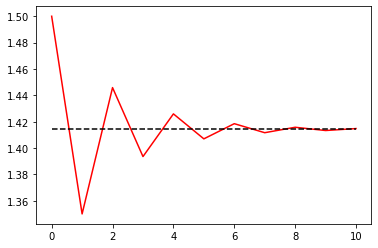

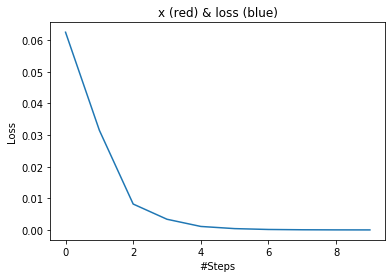

In [25]:
# GradientTape computes gradients with respect to variables. So, we need to
# define `x` as a tf.Variable.
# (Note that gradient computation would return None with dtype=int)
x = tf.Variable(1.5, dtype=tf.float32)
f = lambda x: x * x
x_squared_target = 2.0

learning_rate = 0.1

# Keep values of `x` and `losses` for plotting.
xs = [x.numpy()]
losses = []
for i in range(10):
  with tf.GradientTape() as tape:
    # Compute function value.
    x_squared = f(x)
    # Loss indicates how far off our current guess is.
    # Minimizing loss == finding better value for `x`.
    loss = tf.square(x_squared - x_squared_target)
  grad = tape.gradient(loss, x)
  x.assign_add(-learning_rate * grad)
  xs.append(x.numpy())
  losses.append(loss.numpy())

plt.figure()
plt.plot(xs, 'r-')
sg = xs[-1]/abs(xs[-1])
plt.plot([0, len(xs) - 1], [sg*np.sqrt(x_squared_target)]*2, 'k--')
plt.figure()
plt.plot(losses)
plt.gca().set_title('x (red) & loss (blue)');
plt.xlabel('#Steps')
plt.ylabel('Loss')
print('final difference to solution: {}'.format(
    abs(x.numpy() - x_squared_target**.5)))

# YOUR ACTION REQUIRED:
# Try changing the initial value and the learning rate and see what happens.
# Tip: If you can't converge for some values, try clipping the gradients with
# `tf.clip_by_norm()`.

### Training a linear model

Now let's use gradients to reimplement the linear model from [2_keras.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/2_keras.ipynb)

1. Specifying the training data and labels.
2. Reading and parsing the stored training data into a TF supported format.
3. Training our linear NN model using SGD and the data provided by the previous step. 

**1. Specifying the training data and labels.**

In [26]:
labels = [label.strip() for label 
          in tf.io.gfile.GFile('{}/labels.txt'.format(data_path))]
counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(data_path)))
print('Labels({:d}):\n\t{}'.format(len(labels), labels))
print('Counts:\n\t{}'.format(counts))

Labels(11):
	['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe', 'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
Counts:
	{'eval': 20000, 'test': 10000, 'train': 50000}


**2. Reading and parsing the stored data into a TF supported format.**

In [27]:
# (copied from ./2_keras.ipynb -- see there for comments)
feature_spec = {
    'label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64),
    'img_64': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
  features = tf.io.parse_single_example(serialized_example, feature_spec)
  
  label = features.pop('label')
  label = tf.one_hot(tf.squeeze(label), len(labels))
  
  features['img_64'] = tf.cast(features['img_64'], tf.float32) / 255.
  return features['img_64'], label

batch_size = 100
steps_per_epoch = counts['train'] // batch_size

# Create datasets from `TFRecord` files.
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/train-*'.format(data_path)))
dataset = dataset.map(parse_example)
dataset = dataset.batch(batch_size).repeat()

# Read a single example and display shapes.
for img_feature, label in dataset:
  break
print('img_feature.shape (batch_size, image_height, image_width) =', 
      img_feature.shape)
print('label.shape (batch_size, number_of_labels) =', label.shape)

img_feature.shape (batch_size, image_height, image_width) = (100, 64, 64)
label.shape (batch_size, number_of_labels) = (100, 11)


**Defining the weights and biases.**

The linear model is defined by the following computation:

$$y = Wx + b$$

With
- $y$: Probabilities of the output classes (should approach the one-hot encoded labels).
- $x$: The input (pixel intensities).
- $W$, $b$: model parameters to be learnt via gradient descent.

In [28]:
# Define the variables with the correct dimensions.
W = tf.Variable(tf.random.normal(shape=(
    img_feature.shape[1] * img_feature.shape[2], label.shape[1])))
b = tf.Variable(tf.random.normal(shape=(label.shape[1], )))
W.shape, b.shape

(TensorShape([4096, 11]), TensorShape([11]))

**3. Training our linear NN model using SGD and the data provided by the previous step.**

In [29]:
# YOUR ACTION REQUIRED:
# Adjust the training below to use a decaying learning rate / step size instead
# of using a fixed rate of 0.01.
# (Using a decaying learning rate is often a good idea to make quick progress in
# the beginning but avoid making too big changes to already tuned parameters.)

learning_rate = lambda epoch: 1 / 10**epoch #

# Record values for loss and accuracy for plotting purposes.
losses = []
accs = []
# Train for two epochs.
epochs = 2
for step, (x, y) in enumerate(dataset):
  if step >= epochs * steps_per_epoch:
    break
  # Compute predictions from input and weights.
  with tf.GradientTape() as tape:
    logits = tf.matmul(tf.reshape(x, (x.shape[0], -1)), W) + b
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
  losses.append(loss.numpy())
  W_grad, b_grad = tape.gradient(loss, (W, b))

  # Gradient descent.
  W.assign_add(-learning_rate(step / steps_per_epoch) * W_grad) #W.assign_add(-0.01 * W_grad)
  b.assign_add(-learning_rate(step / steps_per_epoch) * b_grad) #b.assign_add(-0.01 * b_grad)

  # Compute accuracy.
  good_preds = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
  acc = tf.reduce_mean(tf.cast(good_preds, tf.float32))
  accs.append(acc.numpy())
  # Prove we didn't freeze...
  if step and step % 100 == 0:
    print('step={:4d} loss={:2.3f} acc={:.3f}'.format(
        step, np.mean(losses[-100:]), np.mean(accs[-100:])))

step= 100 loss=22.569 acc=0.343
step= 200 loss=14.455 acc=0.431
step= 300 loss=12.478 acc=0.454
step= 400 loss=11.576 acc=0.455
step= 500 loss=11.347 acc=0.453
step= 600 loss=9.650 acc=0.493
step= 700 loss=9.662 acc=0.480
step= 800 loss=9.744 acc=0.474
step= 900 loss=9.783 acc=0.475


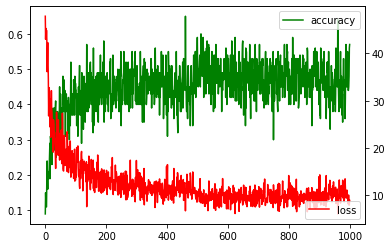

In [30]:
# Plot accuracy (should go up) and loss (should go down).
# Note large variance from one batch to another.
plt.plot(accs, 'g', label='accuracy')
plt.legend(loc='upper right')
plt.grid(False)
plt.twinx().plot(losses, 'r', label='loss')
plt.legend(loc='lower right')
plt.grid(False)

## Keras, revisited

### Models with custom layers

In addition to using Keras in the simplified way as we've seen in `2_keras`,
we can also customize specific layers.

You might want to take a short look at: [TF guide - Keras Custom Layers](https://www.tensorflow.org/tutorials/customization/custom_layers)

Particularly, this requires us to implement a class inheriting from `tf.keras.layers.Layer` and implementing the methods:

1.   `build`
2.   `call`
3.   `compute_output_shape`
4. (optional) `get_config` and `from_config` for layer serialization support

In [0]:
class MyLinearLayer(tf.keras.layers.Layer):

  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim
    super().__init__(**kwargs)

  # Define variables using `self.add_weight()` so Keras knows how to update
  # weights.
  def build(self, input_shape):
    shape = tf.TensorShape((input_shape[1], self.output_dim))
    self.W = self.add_weight(name='W',
                             shape=shape,
                             initializer='normal',
                             trainable=True)
    self.b = self.add_weight(name='b',
                             shape=shape[1:],
                             initializer='normal',
                             trainable=True)
    super().build(input_shape)

  # Compute outputs from inputs (forward pass).
  def call(self, inputs):
    logits = tf.matmul(inputs, self.W) + self.b
    return tf.nn.softmax(logits)

  # Tell Keras how to verify shape conformity of layer stacking.
  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)
  
  # Make layer work with model.get_config() and model.from_config().
  def get_config(self):
    base_config = super().get_config()
    base_config['output_dim'] = self.output_dim
    return base_config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

**Model definition**

We can now define our TF model using `tf.keras.Sequential`.

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
model.add(MyLinearLayer(len(labels)))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
my_linear_layer (MyLinearLay (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


**Training the model**

In [33]:
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1)

Train for 500 steps
500/500 [==============================] - 6s 12ms/step - loss: 1.5230 - accuracy: 0.5094


**Saving and loading a (trained) model**

In [0]:
# Note that the Keras serialized model contains weights and model parameters
# but not the Python code for creating the layers!
# If you save a model with a custom layer then you need to define the layer and
# provide it to .load_model() as an argument so the model can be instantiated:
model.save('./tmp.h5')
loaded_model = tf.keras.models.load_model('./tmp.h5', 
                                          dict(MyLinearLayer=MyLinearLayer))

### Training a bidirectional LSTM

Instead of using the images directly, we can also utilize the stroke data in connection with a recurrent neural network.

Particularly, we will train a bidirectional LSTM by going through the following steps:

1. Data preparation
2. Data inspection
3. Model definition
4. Model training

**1. Data preparation**

The stroke data is available inside `TFRecord` files. Let's inspect the features
of one example first.

In [35]:
data_path_stroke = data_path.replace('_img', '_stroke')
tf_records_file = tf.io.gfile.glob('{}/train-*'.format(data_path_stroke))[0]
print('One TFRecords file:\n\t{}'.format(tf_records_file))
for record in tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/train-*'.format(data_path_stroke))[0]):
  first_example = tf.train.Example.FromString(record.numpy())
  break
print('Features in example:\n\t{}'.format(
    ' '.join(first_example.features.feature.keys())))

One TFRecords file:
	/content/gdrive/My Drive/amld_data/zoo_stroke/train-00000-of-00010
Features in example:
	timestamp key_id recognized countrycode word label stroke_x stroke_y stroke_z stroke_len


Our recurrent neural network will expect dense tensors with fixed lengths. However, the different examples can have variable stroke lengths.

**Note**: The QuickDraw stroke coordinate "sparse tensors" have a single dimension and do not contain any zeros at all.

Let's define a helper function that:

1.   Limits variable length sparse tensors to a maximum length.
2.   Converts them to dense tensors.

In [0]:
def convert_sparse(sparse, max_len):
  """Converts batched sparse tensor to dense tensor with specified size.

  Args:
    sparse: tf.SparseTensor instance of shape=[n].
    max_len: Truncates / zero-pads the dense tensor to have a length equal to 
        this value.
  """
  # Convert to dense tensor.
  dense = tf.sparse.to_dense(sparse)
  # Discard values above `max_len`.
  dense = dense[:max_len]
  # Zero-pad if length < `max_len`.
  dense = tf.pad(dense, [[0, max_len - tf.shape(dense)[0]]])
  return dense

Let's look at an example to see how `convert_sparse()` works.

We will use `stroke_x` as an example `tf.SparseTensor` with the X-coordinates `[1,2,3,4,5]`.

In [37]:
stroke_x = tf.sparse.from_dense(tf.range(5))
# Extract both shorter and longer dense tensors.
dense_short = convert_sparse(stroke_x, max_len=3)
dense_long = convert_sparse(stroke_x, max_len=10)
print('Dense short (max_len=3):\n\t{}'.format(dense_short.numpy()))
print('Dense long (max_len=10):\n\t{}'.format(dense_long.numpy()))

Dense short (max_len=3):
	[0 1 2]
Dense long (max_len=10):
	[0 1 2 3 4 0 0 0 0 0]


In [38]:
labels_stroke = [label.strip() for label in tf.io.gfile.GFile(
    '{}/labels.txt'.format(data_path_stroke))]
counts_stroke = json.load(tf.io.gfile.GFile(
    '{}/counts.json'.format(data_path_stroke)))
print('Labels({:d}):\n\t{}'.format(len(labels_stroke), labels_stroke))
print('Counts:\n\t{}'.format(counts_stroke))

Labels(11):
	['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe', 'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
Counts:
	{'eval': 20000, 'test': 10000, 'train': 50000}


In [0]:
# Maximum number of points in concatenated strokes (exceeding discarded).
MAX_LEN = 256

# Because every drawing has a different number of points, we use `VarLenFeature`
# and not `FixedLenFeature` for the stroke data. This will create a
# `SparseTensor`.
feature_spec_stroke = {
    'stroke_x': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_y': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_z': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_len': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parse_example_stroke(serialized_example):
  """Parses a given tf.Example and creates a dense (limited) length tensor.

  Args:
    serialized_example: tf.Example to parse.
  """
  features = tf.io.parse_single_example(serialized_example, feature_spec_stroke)
  label = features.pop('label')

  # We create a 'stroke' tensor with shape [3, MAX_LEN] where the first
  # dimension indicates whether the values are X, Y, or Z coordinates.
  stroke = tf.stack([
      convert_sparse(features['stroke_x'], max_len=MAX_LEN),
      convert_sparse(features['stroke_y'], max_len=MAX_LEN),
      convert_sparse(features['stroke_z'], max_len=MAX_LEN),
  ])
  stroke = tf.transpose(stroke, perm=[1, 0])

  # Also truncate the `stroke_len` to MAX_LEN if needed.
  stroke_len = tf.minimum(tf.cast(MAX_LEN, tf.int64), features['stroke_len'])

  return stroke, tf.one_hot(label, depth=len(labels_stroke))

def make_ds_stroke(files_pattern, batch_size=100):
  """Converts all data within multiple TFRecord files into a
     dense (limited) length tensor format, shuffles them and creates batches.

  Args:
    files_pattern: Path with the format `[...]/train-*`.
    batch_size: Size to use for generating batches. 
  """
  dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(files_pattern))
  dataset = dataset.map(parse_example_stroke).batch(batch_size)
  dataset = dataset.shuffle(buffer_size=5*batch_size).repeat()
  return dataset

In [0]:
# Adjust the batch size to the given hardware (#accelerators).
batch_size = 100
steps_per_epoch = counts_stroke['train'] // batch_size
eval_steps_per_epoch = counts_stroke['eval'] // batch_size
ds_stroke = make_ds_stroke('{}/train-*'.format(data_path_stroke), batch_size)
ds_stroke_eval = make_ds_stroke('{}/eval-*'.format(data_path_stroke), 
                                batch_size)

**2. Data inspection**

We can now use Matplotlib to visualize the stroke data.

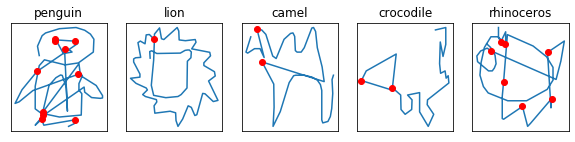

In [41]:
from matplotlib import pyplot as plt

def show_stroke_img(stroke, label, ax=None):
  """Plots stroke data.

  Args:
    stroke: Array of shape=[3, n] where the second dimension
        is time and the first dimension indicates X/Y coordinates
        and Z-dimension that is set to 1 when a stroke ends and
        0 otherwise (the array actually represents an array of
        concatenated strokes and the Z-dimension is needed to tell
        the individual strokes apart).
  """
  ax = ax if ax else plt.gca()
  xy = stroke[:2, :].cumsum(axis=1)
  ax.plot(xy[0, :], -xy[1, :])
  # Plot all the strokes, including connecting line between strokes.
  pxy = xy[:, stroke[2] != 0]
  # Red dots mark end of individual strokes.
  ax.plot(pxy[0], -pxy[1], 'ro')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(label)

# Load a single batch of images:
for x, y in ds_stroke:
  break

# Plot some images
plt.figure(figsize=(10, 2))
for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  show_stroke_img(x[i].numpy().T, labels_stroke[y[i].numpy().argmax()], ax)

**3. Model definition**

While defining a linear model using basic TensorFlow operations was quite easy, defining a bidirectional LSTM would be a nightmare!

Luckily Keras provides us with good implementations of many common network components and putting these together requires only a few lines of code:

In [42]:
lstm_model = tf.keras.Sequential()

# Masking means that we don't do computations on all the `0` used for padding
# of sequences shorter than MAX_LEN.
# While masking is not strictly needed it makes learning a lot faster.
lstm_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(MAX_LEN, 3)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256), 
                                            input_shape=(MAX_LEN, 3)))

lstm_model.add(tf.keras.layers.Dense(len(labels_stroke), activation='softmax'))

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 256, 3)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               532480    
_________________________________________________________________
dense (Dense)                (None, 11)                5643      
Total params: 538,123
Trainable params: 538,123
Non-trainable params: 0
_________________________________________________________________


**4. Training the model**


In [43]:
# This is a pretty heavy model. If you train on CPU you probably want to reduce
# the number of steps.
lstm_model.fit(ds_stroke, steps_per_epoch=steps_per_epoch, epochs=1)
lstm_model.evaluate(ds_stroke_eval, steps=eval_steps_per_epoch)

Train for 500 steps
200/200 [==============================] - 38s 188ms/step - loss: 2.0992 - accuracy: 0.2379 - categorical_accuracy: 0.2379


[2.0992228430509567, 0.2379, 0.2379]

# ----- Optional part -----

## TensorBoard

TensorBoard is a great tool to observe variables during training (especially useful for models training a long time, like above LSTM).

In [44]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
tensorboard_path = './tensorboard/lstm_{}'.format(now)
os.makedirs(tensorboard_path)
tensorboard_path

'./tensorboard/lstm_2020-01-24_22:40:18'

In [0]:
# This callback will make Keras record loss and metrics.
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path, update_freq='batch'),
]

In [0]:
def get_stroke_lengths(strokes):
  """Returns the length of a batch of strokes.

  Args:
    strokes : Dense Tensor with shape `[batch_size, max_length, 3]` that is zero
        padded in the second dimension.

  Returns:
    Vector of stroke lengths (=number of elements in the second dimension that
        are non-zero).
  """
  batch_size, max_length = strokes.shape.as_list()[:2]

  # nonzero.shape = [batch_size, max_length] with `True` for every non-zero
  # element.
  nonzero = tf.greater(
      tf.reduce_sum(tf.cast(tf.greater(strokes, 0), tf.float32), axis=2), 0)
  
  # Return the index of the right-most non-zero element.
  return max_length - tf.argmax(tf.cast(nonzero, tf.float32)[:,::-1], axis=1)

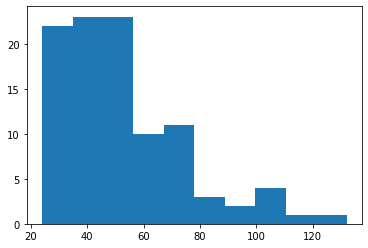

In [47]:
# Check out the stroke length of the first batch.
for x, y in ds_stroke:
  break
plt.hist(get_stroke_lengths(x));

In [0]:
class SummaryRecorder(tf.keras.layers.Layer):
  """A layer that records strokes lengths with `tf.summary`."""

  def __init__(self, optimizer, **kwargs):
    self.optimizer = optimizer
    super().__init__(**kwargs)

  def get_config(self):
    return dict(optimizer=self.optimizer)

  def call(self, strokes):
    stroke_lengths = get_stroke_lengths(strokes)
    step = self.optimizer.iterations
    tf.summary.scalar(
        name='avg_stroke_length', data=tf.reduce_mean(stroke_lengths),
        step=step)
    tf.summary.histogram(
        name='stroke_lengths', data=stroke_lengths, step=step)
    return strokes

In [49]:
# Code copied from section "Training a bidirectional LSTM", but with an
# additional Lambda layer for the recording of the stroke lengths:
optimizer = tf.keras.optimizers.Adam(0.05)

lstm_model = tf.keras.Sequential()
lstm_model.add(SummaryRecorder(optimizer, input_shape=(MAX_LEN, 3)))
lstm_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(MAX_LEN, 3)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256)))
lstm_model.add(tf.keras.layers.Dense(len(labels_stroke), activation='softmax'))

lstm_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
summary_recorder (SummaryRec (None, 256, 3)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 256, 3)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               532480    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 538,123
Trainable params: 538,123
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Forwarding of TensorBoard's 6006 port using https://ngrok.com

# Download & unzip ngrok
!if [ ! -f ngrok ]; then \
 wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip; \
 unzip -o ngrok-stable-linux-amd64.zip; \
 fi

# Start TensorBoard
!pkill tensorboard
get_ipython().system_raw(
    'tensorboard --reload_interval 0 --logdir ./tensorboard --port 6006 &'
)

In [58]:
# Open a new ngrok tunnel. Re-execute this cell if you run into quota issues
# ("Too many connections").

!pkill ngrok
# Forward port.
get_ipython().system_raw('./ngrok http 6006 &')
# Give some time to start up.
!sleep 1
# Output external address (ngrok's web interface listens at 4004).
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://9c7d7630.ngrok.io


Open TensorBoard in a seaprate tab by clicking on the above link.

In [52]:
# Summary writers store information logged via `tf.summary.*` to disk for
# inspection by TensorBoard.
summary_writer = tf.summary.create_file_writer(
    os.path.join(tensorboard_path, 'strokes'), flush_millis=1000)

# Then let's create a new model and train it again.
# Check out TensorBoard during training (click on the "refresh" button to see
# new data).
with summary_writer.as_default():
  history = lstm_model.fit(
      ds_stroke, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=callbacks)

Train for 500 steps
500/500 [==============================] - 300s 601ms/step - loss: 2.3841 - accuracy: 0.1956 - categorical_accuracy: 0.1956


In [53]:
# Summaries are stored as "events.out.tfevents.*" files.
!find ./tensorboard

./tensorboard
./tensorboard/lstm_2020-01-24_22:40:18
./tensorboard/lstm_2020-01-24_22:40:18/strokes
./tensorboard/lstm_2020-01-24_22:40:18/strokes/events.out.tfevents.1579905636.85a5fdbaa5d7.123.105792.v2
./tensorboard/lstm_2020-01-24_22:40:18/train
./tensorboard/lstm_2020-01-24_22:40:18/train/events.out.tfevents.1579905649.85a5fdbaa5d7.profile-empty
./tensorboard/lstm_2020-01-24_22:40:18/train/plugins
./tensorboard/lstm_2020-01-24_22:40:18/train/plugins/profile
./tensorboard/lstm_2020-01-24_22:40:18/train/plugins/profile/2020-01-24_22-40-49
./tensorboard/lstm_2020-01-24_22:40:18/train/plugins/profile/2020-01-24_22-40-49/local.trace
./tensorboard/lstm_2020-01-24_22:40:18/train/events.out.tfevents.1579905636.85a5fdbaa5d7.123.105810.v2


In [0]:
# YOUR ACTION REQUIRED:
# How does the accuracy develop over time? You can rerun the training cell to
# train more epochs and append more data to the summaries.
# You can also define new models with different parameters (optimizer learning
# rate, cell size, ...) and compare model performance in TensorBoard. Rerun the
# cell that defines tensorboard_path to store the summaries in different
# directories.

## TPU Support

As we did in the previous notebook, we'll need to do some adjustments to train our models on a TPU (works only on Colab).

> **Attention:** Please make sure to switch the runtime to TPU for this part. You can do so via: "Runtime > Change runtime type > Hardware Accelerator" in Colab. As this might create a new environment this section can be executed isolated from anything above.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import json, os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# Disable duplicate logging output in TF.
logger = tf.get_logger()
logger.propagate = False

# This will fail if no TPU is connected...
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# Set up distribution strategy.
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu);
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Tested with TensorFlow 2.1.0
print('\n\nTF version={} TPUs={} accelerators={}'.format(
    tf.__version__, tpu.cluster_spec().as_dict()['worker'],
    strategy.num_replicas_in_sync))

INFO:tensorflow:Initializing the TPU system: 10.1.115.26:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflo

> **Attention:** TPUs require all files (input and models) to be stored in cloud storage buckets (`gs://bucket-name/...`). If you plan to use TPUs please choose the `data_path` below accordingly. Otherwise, you might run into `File system scheme '[local]' not implemented` errors.

In [0]:
from google.colab import auth
auth.authenticate_user()

# Browse datasets:
# https://console.cloud.google.com/storage/browser/amld-datasets

# - 50k training examples, including pickled DataFrame.
data_path_stroke = 'gs://amld-datasets/zoo_stroke_small'
# - 1M training examples, without pickled DataFrame.
# data_path_stroke = 'gs://amld-datasets/zoo_stroke'
# - 4.1M training examples, without pickled DataFrame.
# data_path_stroke = 'gs://amld-datasets/animals_stroke'
# - 29M training examples, without pickled DataFrame.
# data_path_stroke = 'gs://amld-datasets/all_stroke'

In [4]:
#@markdown **Copied and adjusted data definition code from above**
#@markdown
#@markdown &nbsp;&nbsp; Note: You can double-click this cell to see its code.
#@markdown
#@markdown The changes have been highlighted with `!` in the contained code
#@markdown (things like the `batch_size` and added `drop_remainder=True`).
#@markdown
#@markdown Feel free to just **click "execute"** and ignore the details for now.

tf_records_file = tf.io.gfile.glob('{}/train-*'.format(data_path_stroke))[0]
print('One TFRecords file:\n\t{}'.format(tf_records_file))
for record in tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/train-*'.format(data_path_stroke))[0]):
  first_example = tf.train.Example.FromString(record.numpy())
  break
print('Features in example:\n\t{}'.format(
    ' '.join(first_example.features.feature.keys())))

def convert_sparse(sparse, max_len):
  """Converts batched sparse tensor to dense tensor with specified size.

  Args:
    sparse: tf.SparseTensor instance of shape=[n].
    max_len: Truncates / zero-pads the dense tensor to have a length equal to 
        this value.
  """
  # Convert to dense tensor.
  dense = tf.sparse.to_dense(sparse)
  # Discard values above `max_len`.
  dense = dense[:max_len]
  # Zero-pad if length < `max_len`.
  dense = tf.pad(dense, [[0, max_len - tf.shape(dense)[0]]])
  # TPU does not support dynamic shapes.
  dense = tf.reshape(dense, [max_len])
  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  return dense

labels_stroke = [label.strip() for label in tf.io.gfile.GFile(
    '{}/labels.txt'.format(data_path_stroke))]
counts_stroke = json.load(tf.io.gfile.GFile(
    '{}/counts.json'.format(data_path_stroke)))
print('Labels({:d}):\n\t{}'.format(len(labels_stroke), labels_stroke))
print('Counts:\n\t{}'.format(counts_stroke))

# Maximum number of points in concatenated strokes (exceeding discarded).
MAX_LEN = 256

# Because every drawing has a different number of points, we use `VarLenFeature`
# and not `FixedLenFeature` for the stroke data. This will create a
# `SparseTensor`.
feature_spec_stroke = {
    'stroke_x': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_y': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_z': tf.io.VarLenFeature(dtype=tf.float32),
    'stroke_len': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parse_example_stroke(serialized_example):
  """Parses a given tf.Example and creates a dense (limited) length tensor.

  Args:
    serialized_example: tf.Example to parse.
  """
  features = tf.io.parse_single_example(serialized_example, feature_spec_stroke)
  label = features.pop('label')

  # We create a 'stroke' tensor with shape [3, MAX_LEN] where the first
  # dimension indicates whether the values are X, Y, or Z coordinates.
  stroke = tf.stack([
      convert_sparse(features['stroke_x'], max_len=MAX_LEN),
      convert_sparse(features['stroke_y'], max_len=MAX_LEN),
      convert_sparse(features['stroke_z'], max_len=MAX_LEN),
  ])
  stroke = tf.transpose(stroke, perm=[1, 0])

  # Also truncate the `stroke_len` to MAX_LEN if needed.
  stroke_len = tf.minimum(tf.cast(MAX_LEN, tf.int64), features['stroke_len'])

  return stroke, tf.one_hot(label, depth=len(labels_stroke))

def make_ds_stroke(files_pattern, batch_size=100):
  """Converts all data within multiple TFRecord files into a
     dense (limited) length tensor format, shuffles them and creates batches.

  Args:
    files_pattern: Path with the format `[...]/train-*`.
    batch_size: Size to use for generating batches. 
  """
  dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(files_pattern))
  dataset = dataset.map(parse_example_stroke).batch(batch_size, drop_remainder=True)
  dataset = dataset.shuffle(buffer_size=5*batch_size).repeat()
  return dataset

# Adjust the batch size to the given hardware (#accelerators).
batch_size = 64 * strategy.num_replicas_in_sync
#            !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
steps_per_epoch = counts_stroke['train'] // batch_size
eval_steps_per_epoch = counts_stroke['eval'] // batch_size
ds_stroke = make_ds_stroke('{}/train-*'.format(data_path_stroke), batch_size)
ds_stroke_eval = make_ds_stroke('{}/eval-*'.format(data_path_stroke), 
                                batch_size)

One TFRecords file:
	gs://amld-datasets/zoo_stroke_small/train-00000-of-00010
Features in example:
	stroke_len timestamp key_id recognized countrycode word label stroke_x stroke_y stroke_z
Labels(11):
	['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe', 'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
Counts:
	{'eval': 10000, 'test': 20000, 'train': 50000}


In [5]:
# Model definition code needs to be wrapped in scope.
with strategy.scope():
  lstm_model = tf.keras.Sequential()
  lstm_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(MAX_LEN, 3)))
  lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256), 
                                              input_shape=(MAX_LEN, 3)))
  lstm_model.add(tf.keras.layers.Dense(len(labels_stroke), activation='softmax'))

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 256, 3)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               532480    
_________________________________________________________________
dense (Dense)                (None, 11)                5643      
Total params: 538,123
Trainable params: 538,123
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Note the massive speedup (compared to above, we train 10x more) !
lstm_model.fit(ds_stroke, steps_per_epoch=steps_per_epoch, epochs=10)
lstm_model.evaluate(ds_stroke_eval, steps=eval_steps_per_epoch)

Train for 97 steps
Epoch 1/10
97/97 [==============================] - 34s 352ms/step - loss: 2.3626 - accuracy: 0.1496 - categorical_accuracy: 0.1496
Epoch 2/10
97/97 [==============================] - 6s 59ms/step - loss: 2.1414 - accuracy: 0.2402 - categorical_accuracy: 0.2402
Epoch 3/10
97/97 [==============================] - 6s 58ms/step - loss: 1.5959 - accuracy: 0.4396 - categorical_accuracy: 0.4396
Epoch 4/10
97/97 [==============================] - 5s 56ms/step - loss: 1.0848 - accuracy: 0.6245 - categorical_accuracy: 0.6245
Epoch 5/10
97/97 [==============================] - 5s 55ms/step - loss: 0.7881 - accuracy: 0.7358 - categorical_accuracy: 0.7358
Epoch 6/10
97/97 [==============================] - 6s 58ms/step - loss: 0.5975 - accuracy: 0.7974 - categorical_accuracy: 0.7974
Epoch 7/10
97/97 [==============================] - 6s 58ms/step - loss: 0.4737 - accuracy: 0.8425 - categorical_accuracy: 0.8425
Epoch 8/10
97/97 [==============================] - 5s 55ms/step - lo

[0.3374069615414268, 0.8856908, 0.8856908]